Principal components analysis

In [1]:
# Matrice des composantes principales
import numpy as np

X1 = np.random.rand(100,1)
X2 = 1 + 2*X1 + np.random.randn(100,1)
X = np.hstack((X1, X2))

X_centered = X - X.mean(axis=0)
U, s, V = np.linalg.svd(X_centered)
c1 = V.T[:, 0]
c2 = V.T[:, 1]
print(c1, c2)

[0.15875228 0.98731845] [-0.98731845  0.15875228]


In [2]:
# Projection
W2 = V.T[:, :2]
X1D = X_centered.dot(W2)

In [3]:
# PCA implémente une analyse par composantes principales
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X1D = pca.fit_transform(X)
pca.components_.T[:, 0]

array([0.15875228, 0.98731845])

In [4]:
# Taux de contribution à la variance de chaque composante
print(pca.explained_variance_ratio_)

[0.95538639 0.04461361]


In [5]:
# Choisir la bonne dimension
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1  # On obtient ainsi d optimal

In [6]:
# Plus efficace
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)

In [7]:
# Exemple sur la base de donnée MNIST
from sklearn.datasets import fetch_openml  # Chargement de la base de données MNIST originale
mnist = fetch_openml('mnist_784', version=1, parser='auto')

In [8]:
X, y = mnist['data'], mnist['target']  # X et y sont des DataFrame et non des tableaux NumPy
X = X.to_numpy()
y = y.to_numpy()
y = y.astype(int)  # Important sinon les éléments de y ne sont pas considérés comme des entiers

In [9]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)
pca.n_components_

154

In [10]:
# PCA incrémental, dans le cas où le jeu d'entraînement tout entier ne tient pas en mémoire
from sklearn.decomposition import IncrementalPCA
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

In [11]:
# Autre idée : utilisation de memmap qui ne charge en mémoire que ce qui est utilisé

In [12]:
# Option plus rapide : PCA randomisée
rnd_pca = PCA(n_components=154, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(X_train)

Kernel PCA

In [13]:
from sklearn.decomposition import KernelPCA

X_subset = X[:1000]  # Jeu trop volumineux
y_subset = y[:1000]

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X_subset)

In [14]:
# Sélectionner un noyau et régler les hyperparamètres
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression())
    ])
param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_subset, y_subset)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [15]:
print(grid_search.best_params_)

{'kpca__gamma': 0.03, 'kpca__kernel': 'rbf'}


In [16]:
# Trouver le noyau et les hyperparamètres adéquats dans le cas non supervisé :
# On cherche à minimiser la perte d'information, c'est à dire à pouvoir reconstruire 
# un jeu de donnée à partir de son image de la manière la plus précise possible.
rbf_pca = KernelPCA(n_components=1, kernel='rbf', gamma=0.03, fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X_subset)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [17]:
from sklearn.metrics import mean_squared_error, make_scorer
mean_squared_error(X_subset, X_preimage)

4278.31899097874

In [18]:
# Jeu de données Swiss roll
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

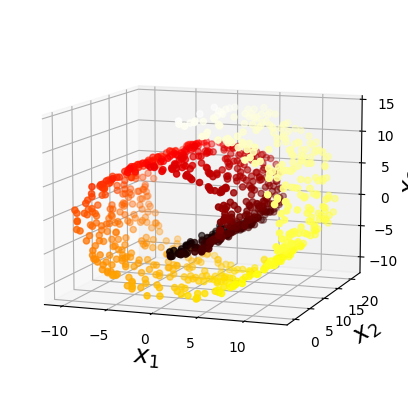

In [19]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

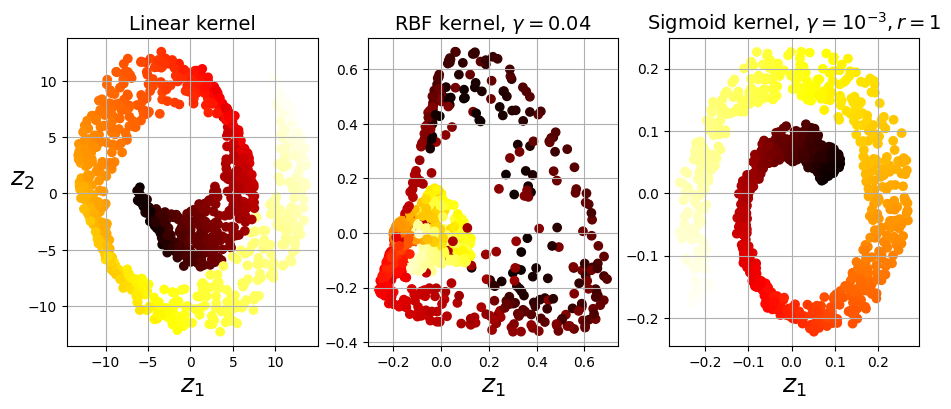

In [20]:
lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

Locally linear embedding (LLE)

In [21]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

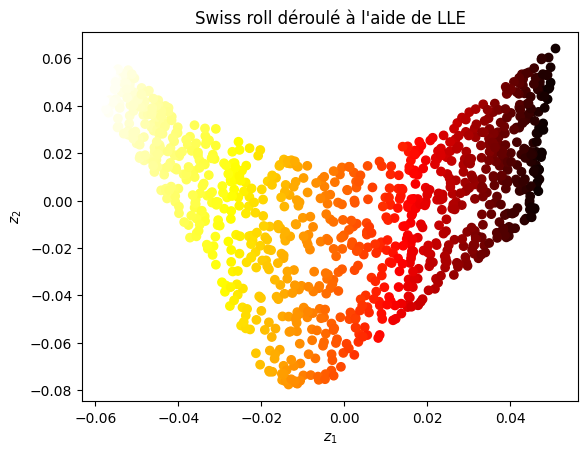

In [22]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.title("Swiss roll déroulé à l'aide de LLE")
plt.show()

Exercices

In [23]:
from sklearn.datasets import fetch_openml  # Chargement de la base de données MNIST originale
mnist = fetch_openml('mnist_784', version=1, parser='auto')
X, y = mnist['data'], mnist['target']  # X et y sont des DataFrame et non des tableaux NumPy
X = X.to_numpy()
y = y.to_numpy()
y = y.astype(int)  # Important sinon les éléments de y ne sont pas considérés comme des entiers
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [24]:
# Sans réduction de dimension
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [25]:
import time

t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()

print("Temps de calcul {:.2f}s".format(t1 - t0))

Temps de calcul 39.31s


In [26]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9705

In [27]:
# Avec réduction de dimension
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

rnd_clf2 = RandomForestClassifier(n_estimators=100, random_state=42)

t0 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

print("Temps de calcul {:.2f}s".format(t1 - t0))

Temps de calcul 114.15s


In [28]:
X_test_reduced = pca.transform(X_test)
y_pred= rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9481

In [39]:
# Réduction des données MNIST à 2 dimensions
m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist.data.iloc[idx]
y = mnist.target.iloc[idx]
y = y.astype(int)

In [40]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

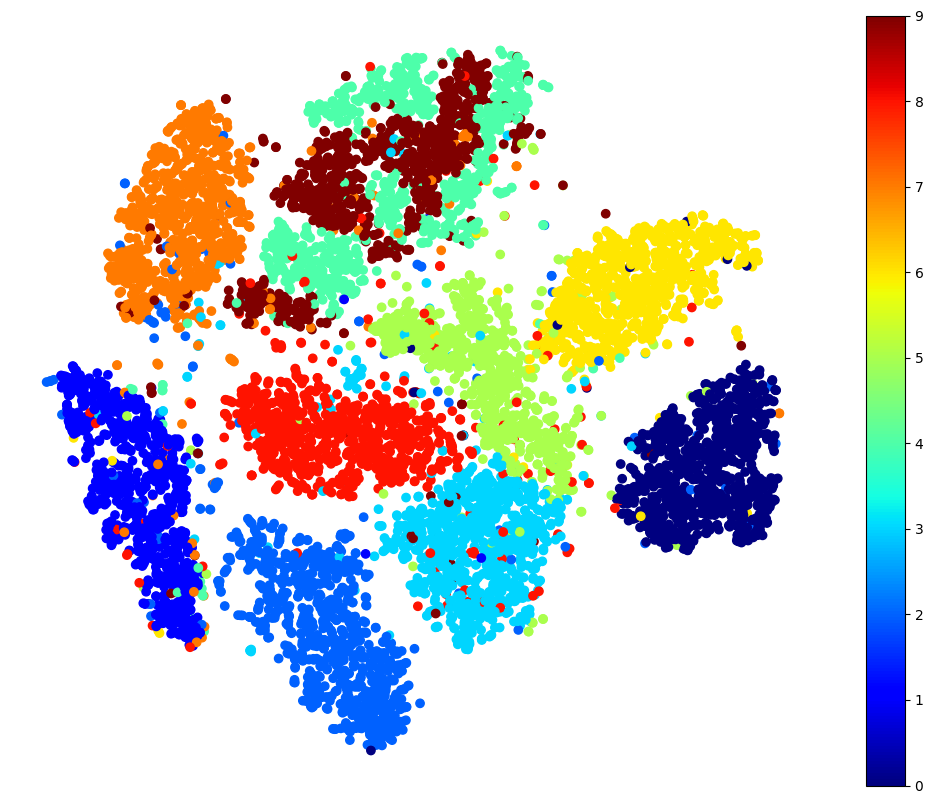

In [41]:
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()